In [32]:
#Automatically detect market volatility regimes from data.

In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv(r"C:\Data Science Learning\Projects\Volatility Regime Detection in Stock Returns\data\03_Feature_Extraction\nifty_features.csv")

In [35]:
df.head()

,date,close,turnover,log_returns,abs_returns,vol_7,vol_14,vol_30,volumn_change
0,2014-02-12,6084.00,5351.08,0.003507,0.003507,0.002187,0.007891,0.007648,0.015616
1,2014-02-13,6001.10,5037.18,-0.013720,0.013720,0.006368,0.008009,0.007694,-0.058661
2,2014-02-14,6048.35,5539.70,0.007843,0.007843,0.006945,0.006616,0.007869,0.099762
3,2014-02-17,6073.30,4455.65,0.004117,0.004117,0.007051,0.006753,0.007908,-0.195687
4,2014-02-18,6127.10,4592.38,0.008819,0.008819,0.007594,0.007206,0.008052,0.030687


In [36]:
#HMM only sees log_returns because HMM assumes stationary observations 
#Prices are non-stationary
#Returns are stationary-ish

In [37]:
X = df["log_returns"].dropna().values.reshape(-1,1)

In [38]:
X

array([[ 0.00350713],
       [-0.01371959],
       [ 0.00784272],
       ...,
       [-0.00160801],
       [-0.0001162 ],
       [ 0.00582637]])

In [39]:
#We are chosing 3 Regimes 
#0 - Low Volatility:- Calm Periods
#1 - Medium / Normal:- Volatility Noisy Transitions
#2 - High Volatility:- Crisis Spikes

In [40]:
from hmmlearn.hmm import GaussianHMM

hmm = GaussianHMM(
    n_components = 3,
    covariance_type = "full",
    n_iter = 1000,
    random_state = 42
)

In [41]:
hmm.fit(X)

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [42]:
hidden_states = hmm.predict(X)

In [43]:
df = df.iloc[-len(hidden_states):].copy()
df["regime"] = hidden_states

In [44]:
df.head()

,date,close,turnover,log_returns,abs_returns,vol_7,vol_14,vol_30,volumn_change,regime
0,2014-02-12,6084.00,5351.08,0.003507,0.003507,0.002187,0.007891,0.007648,0.015616,0
1,2014-02-13,6001.10,5037.18,-0.013720,0.013720,0.006368,0.008009,0.007694,-0.058661,1
2,2014-02-14,6048.35,5539.70,0.007843,0.007843,0.006945,0.006616,0.007869,0.099762,0
3,2014-02-17,6073.30,4455.65,0.004117,0.004117,0.007051,0.006753,0.007908,-0.195687,1
4,2014-02-18,6127.10,4592.38,0.008819,0.008819,0.007594,0.007206,0.008052,0.030687,0


In [45]:
df.groupby("regime")[["log_returns","abs_returns","vol_14"]].mean()

,log_returns,abs_returns,vol_14
regime,,,
0,0.000989,0.006064,0.007949
1,0.000201,0.005931,0.007894
2,-0.000474,0.023832,0.022546


In [46]:
#The HMM automatically identified three distinct market regimes:
#low-volatility bullish phase, a sideways consolidation phase, 
#and a high-volatility stress phase characterized by negative returns and large price swings.

In [47]:
regime_map = {
    0:"Low Vol Bull",
    1:"Low Vol Sideways",
    2:"High Vol Stress"
}

df["regime_label"] = df["regime"].map(regime_map)

In [48]:
df.head()

,date,close,turnover,log_returns,abs_returns,vol_7,vol_14,vol_30,volumn_change,regime,regime_label
0,2014-02-12,6084.00,5351.08,0.003507,0.003507,0.002187,0.007891,0.007648,0.015616,0,Low Vol Bull
1,2014-02-13,6001.10,5037.18,-0.013720,0.013720,0.006368,0.008009,0.007694,-0.058661,1,Low Vol Sideways
2,2014-02-14,6048.35,5539.70,0.007843,0.007843,0.006945,0.006616,0.007869,0.099762,0,Low Vol Bull
3,2014-02-17,6073.30,4455.65,0.004117,0.004117,0.007051,0.006753,0.007908,-0.195687,1,Low Vol Sideways
4,2014-02-18,6127.10,4592.38,0.008819,0.008819,0.007594,0.007206,0.008052,0.030687,0,Low Vol Bull


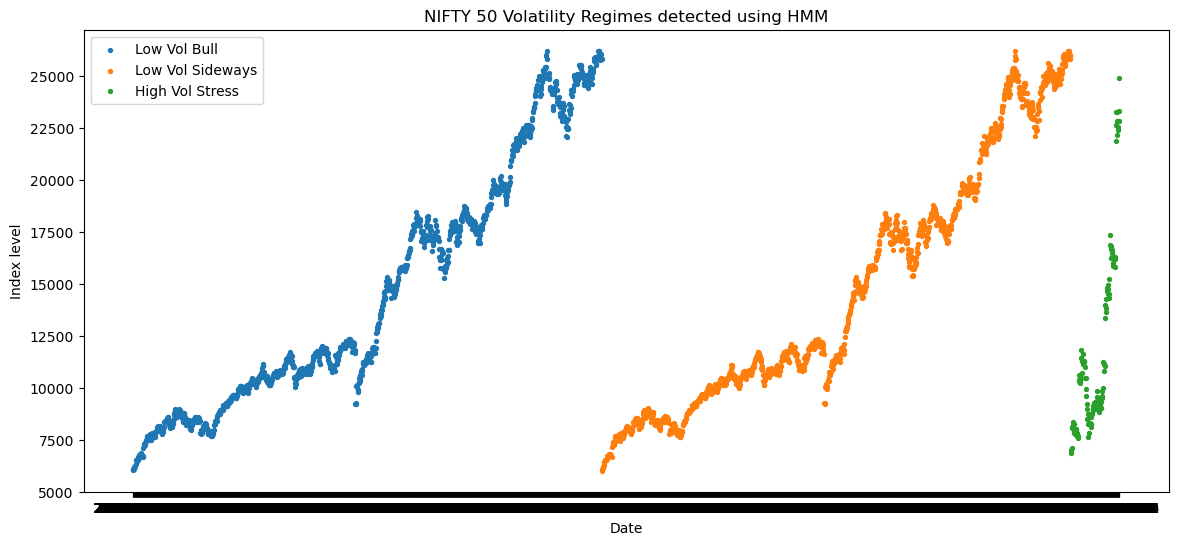

In [50]:
plt.figure(figsize=(14,6))

for regime in df["regime"].unique():
    subset = df[df["regime"] == regime]
    plt.scatter(
        subset["date"],
        subset["close"],
        label = regime_map[regime],
        s=8
    )
plt.legend()
plt.title("NIFTY 50 Volatility Regimes detected using HMM")
plt.xlabel("Date")
plt.ylabel("Index level")
plt.show()

In [77]:
#The HMM has segmented the NIFTY 50 index into distinct volatility regimes, each corresponding to different market behaviors.

In [ ]:
#The HMM effectively captured latent market states that align with known market behaviors such as bull runs, consolidations, and stress periods

Transition probability Matrix: -

In [80]:
#How likely is the market to move from calm to -> stress ?

In [82]:
trans_mat = pd.DataFrame(
    hmm.transmat_,
    columns=["Low vol bull","Low vol side","High vol stress"],
    index=["Low vol bull","Low vol side","High vol stress"]
)
trans_mat

,Low vol bull,Low vol side,High vol stress
Low vol bull,0.000695,0.999298,0.000006
Low vol side,0.974604,0.006035,0.019362
High vol stress,0.140695,0.024865,0.834440


The transition probability matrix reveals clear and intuitive market dynamics. Low volatility bull phases are short-lived and almost always transition into a low volatility sideways regime, indicating that strong upward trends typically cool off into consolidation rather than collapsing abruptly. The sideways regime acts as a buffer state, most frequently transitioning back into a bull phase but occasionally moving into a high volatility stress regime. High volatility stress regimes, although rare, are highly persistent once entered, suggesting that periods of market turbulence tend to cluster over time. Recovery from stress is more likely to occur directly into a bull regime rather than gradually through a sideways phase. Overall, the transition structure aligns well with known financial market behavior, validating the effectiveness of the HMM in capturing latent volatility regimes.

In [ ]:
#Regime Duration Analysis
df["regime_change"] = df["regime"].ne(df["regime"].shift())
df["regime_group"] = df["regime_change"].cumsum()

regime_duration = (
    df.groupby(["regime","regime_group"])
    .size()
    .groupby("regime")
    .mean()
)

In [90]:
regime_duration

regime
0    1.0
1    1.0
2    7.0
dtype: float64

In [ ]:
#These values represent the average duration (in trading days) that the market stays in each regime before switching to another regime.

The regime duration analysis shows a clear asymmetry in market behavior across volatility states. Low volatility bull and sideways regimes are short-lived, with an average duration of approximately one trading day, indicating frequent transitions during calm market conditions. In contrast, the high volatility stress regime persists significantly longer, averaging around seven consecutive trading days. This highlights the phenomenon of volatility clustering, where periods of market stress tend to sustain once triggered. These findings reinforce the regime transition results and further validate the HMM’s ability to capture realistic market dynamics.